In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2020-06-18 06:01:21--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 2607:f8b0:400c:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   121MB/s    in 0.5s    

2020-06-18 06:01:22 (121 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('..input/')
zip_ref.close()

In [4]:
base_dir = '..input/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


In [5]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.209.jpg', 'cat.638.jpg', 'cat.232.jpg', 'cat.100.jpg', 'cat.714.jpg', 'cat.171.jpg', 'cat.447.jpg', 'cat.587.jpg', 'cat.286.jpg', 'cat.270.jpg']
['dog.118.jpg', 'dog.687.jpg', 'dog.239.jpg', 'dog.726.jpg', 'dog.960.jpg', 'dog.101.jpg', 'dog.670.jpg', 'dog.468.jpg', 'dog.722.jpg', 'dog.923.jpg']


In [6]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [7]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model


In [8]:
from tensorflow.keras.optimizers import RMSprop
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
from tensorflow.keras.applications.inception_v3 import InceptionV3



--2020-06-18 06:01:24--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 2607:f8b0:400c:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   134MB/s    in 0.6s    

2020-06-18 06:01:25 (134 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [9]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  


last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [10]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
train_datagen = ImageDataGenerator( rescale = 1.0/255. ,width_shift_range=0.2,height_shift_range=0.2,rotation_range=45,
                                   shear_range=0.2,zoom_range=0.2,
                                   horizontal_flip=True,fill_mode='nearest')
test_datagen  = ImageDataGenerator( rescale = 1.0/255. ,width_shift_range=0.2,height_shift_range=0.2,rotation_range=45,
                                   shear_range=0.2,zoom_range=0.2,
                                   horizontal_flip=True,fill_mode='nearest' )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_steps=50,
                              verbose=2)

Epoch 1/20
100/100 - 38s - loss: 1.7565 - accuracy: 0.8285 - val_loss: 0.5138 - val_accuracy: 0.8790
Epoch 2/20
100/100 - 36s - loss: 0.4433 - accuracy: 0.8845 - val_loss: 0.3684 - val_accuracy: 0.8880
Epoch 3/20
100/100 - 35s - loss: 0.3418 - accuracy: 0.9045 - val_loss: 0.3037 - val_accuracy: 0.9030
Epoch 4/20
100/100 - 35s - loss: 0.3328 - accuracy: 0.8990 - val_loss: 0.2517 - val_accuracy: 0.9170
Epoch 5/20
100/100 - 34s - loss: 0.2958 - accuracy: 0.9160 - val_loss: 0.2273 - val_accuracy: 0.9140
Epoch 6/20
100/100 - 34s - loss: 0.2867 - accuracy: 0.9120 - val_loss: 0.3382 - val_accuracy: 0.8830
Epoch 7/20
100/100 - 34s - loss: 0.2457 - accuracy: 0.9250 - val_loss: 0.2846 - val_accuracy: 0.9210
Epoch 8/20
100/100 - 34s - loss: 0.2076 - accuracy: 0.9300 - val_loss: 0.2407 - val_accuracy: 0.9230
Epoch 9/20
100/100 - 35s - loss: 0.2232 - accuracy: 0.9210 - val_loss: 0.2592 - val_accuracy: 0.9280
Epoch 10/20
100/100 - 33s - loss: 0.2439 - accuracy: 0.9320 - val_loss: 0.1608 - val_accura

In [22]:
from keras.preprocessing import image
import numpy as np
path = "../input/testing-data-images/427.jpg"
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])
if classes[0]>0.5:
    print( " is a dog")
else:
    print(" is a cat")
 

[1.]
 is a dog


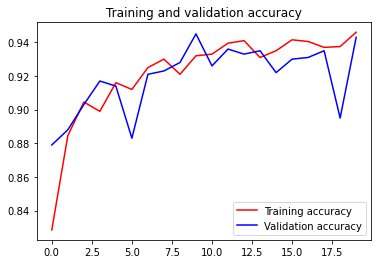

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()